# Exploring relationship between Siacoin (SC), MaidSafeCoin (MAID), and Storjcoin (SJRX)

## John McKenzie

In [4]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import datetime as dt

df=pd.read_html('https://coinmarketcap.com/currencies/storjcoin-x/historical-data/?start=20130428&end=20171124')
SJCX=pd.DataFrame(df[0])
SJCX['Date'] =pd.to_datetime(SJCX.Date)
SJCX.sort_values(by='Date',ascending=True,inplace=True)
SJCX.set_index('Date',inplace=True)

df1=pd.read_html('https://coinmarketcap.com/currencies/siacoin/historical-data/?start=20130428&end=20171124')
SC=pd.DataFrame(df1[0])
SC['Date'] =pd.to_datetime(SC.Date)
SC.sort_values(by='Date',ascending=True,inplace=True)
SC.set_index('Date',inplace=True)

df2=pd.read_html('https://coinmarketcap.com/currencies/maidsafecoin/historical-data/?start=20130428&end=20171124')
MAID=pd.DataFrame(df2[0])
MAID['Date'] =pd.to_datetime(MAID.Date)
MAID.sort_values(by='Date',ascending=True,inplace=True)
MAID.set_index('Date',inplace=True)

In [46]:
print(SJCX['Volume'].head())
avgvol_sj=SJCX['Volume'].mean()
print(avgvol_sj)
avgvol_sc=SC['Volume'].mean()
print(avgvol_sc)
avgvol_ma=MAID['Volume'].mean()
print(avgvol_ma)

Date
2014-08-20    2428
2014-08-21    1408
2014-08-22    4187
2014-08-23    5749
2014-08-25    3876
Name: Volume, dtype: int64
113768.625
3112297.333739342
624123.2104055088


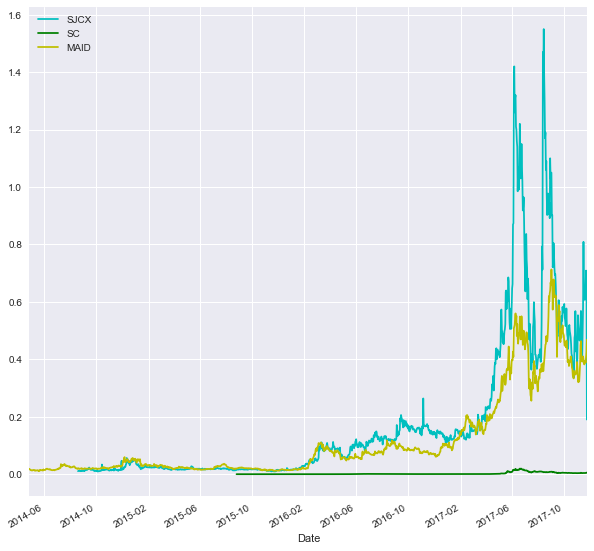

In [5]:
%matplotlib inline
plt.figure(figsize=(10,10))
SJCX['Close'].plot(color='c',label='SJCX');
plt.legend();
SC['Close'].plot(color='g',label='SC');
plt.legend();
MAID['Close'].plot(color='y',label='MAID');
plt.legend();

## Exploratory data analysis

### We produce histogram, sample ACF, and sample PACF for each currency

In [6]:
from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

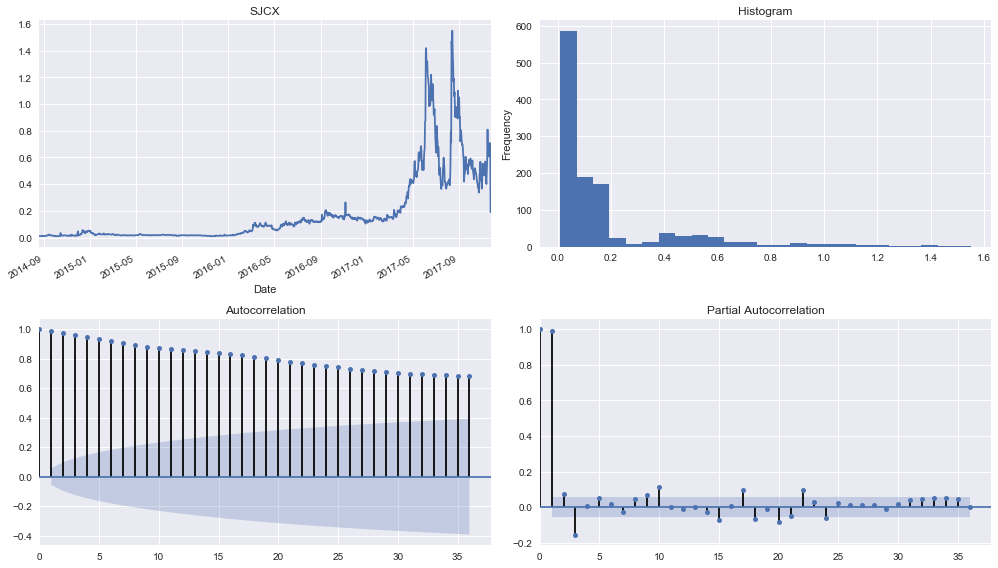

In [7]:
tsplot(SJCX['Close'], title='SJCX', lags=36);

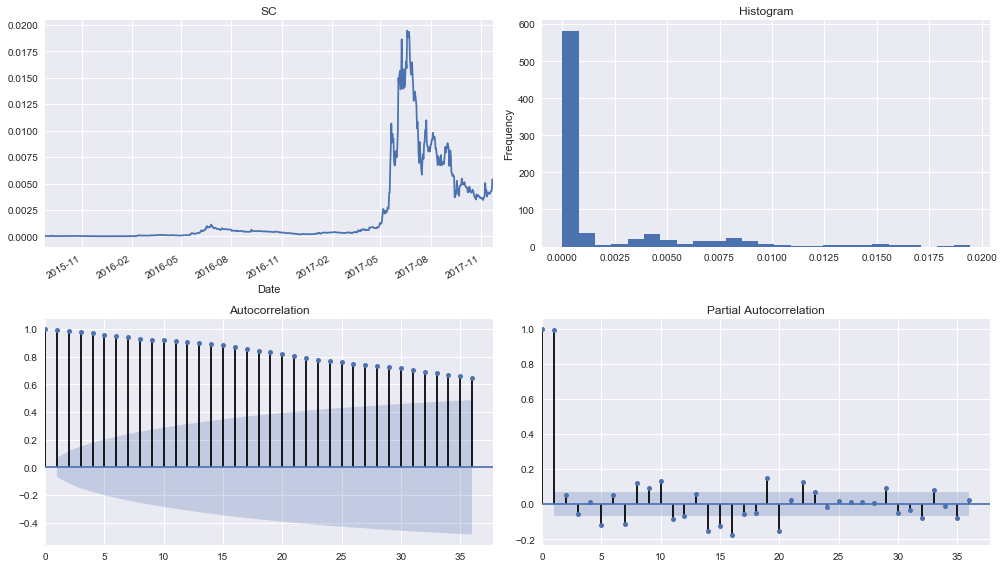

In [8]:
tsplot(SC['Close'], title='SC', lags=36);

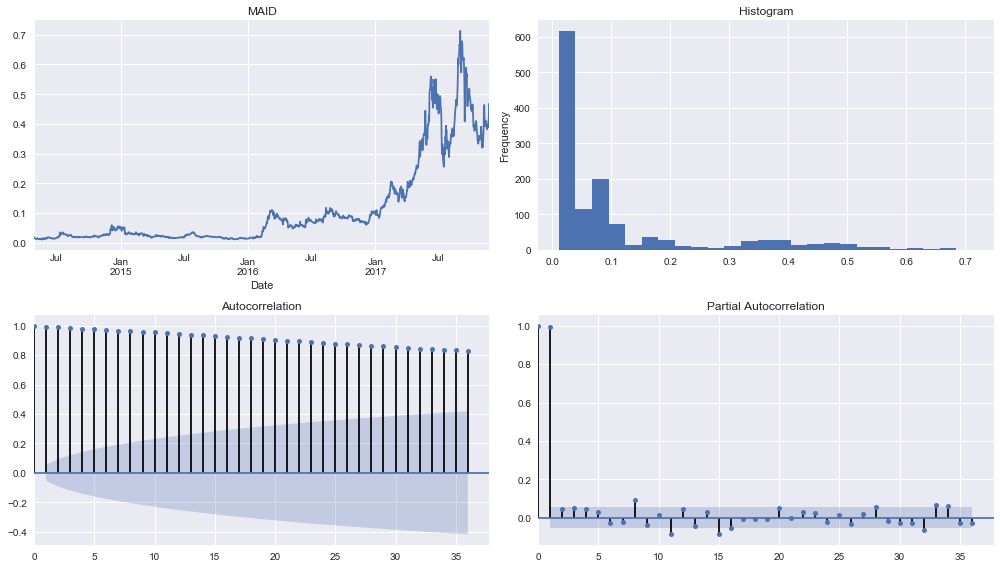

In [9]:
tsplot(MAID['Close'], title='MAID', lags=36);

### We now proceed to test for cointegration

First we need to test if the closing price series are cointegrated processes. We test this using the ADF-test of unit roots.

$H_{0}$: unit root

Returns:

- adf: float
    Test statistic
- pvalue : float
    MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)
- usedlag : int
    Number of lags used
- nobs : int
    Number of observations used for the ADF regression and calculation of the critical values
- critical values : dict
    Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)
- icbest : float
    The maximized information criterion if autolag is not None.
- resstore : ResultStore, optional
    A dummy class with results attached as attributes

In [10]:
print(smt.stattools.adfuller(SJCX['Close'],regression='c',autolag='AIC')[1])
print(smt.stattools.adfuller(SC['Close'],regression='c',autolag='AIC')[1])
print(smt.stattools.adfuller(MAID['Close'],regression='c',autolag='AIC')[1])

0.124999865579
0.179634445766
0.802094160561


For all three close series we **do not reject the null of unit root**. We now need to know the degree of their integrated components.

In [11]:
SJCXdiff1=SJCX['Close'].diff(periods=1)
SCdiff1=SC['Close'].diff(periods=1)
MAIDdiff1=MAID['Close'].diff(periods=1)

Test for unit root again

In [12]:
dSJCX=SJCXdiff1.dropna()
dSC=SCdiff1.dropna()
dMAID=MAIDdiff1.dropna()

print(smt.stattools.adfuller(dSJCX,regression='c',autolag='AIC')[1])
print(smt.stattools.adfuller(dSC,regression='c',autolag='AIC')[1])
print(smt.stattools.adfuller(dMAID,regression='c',autolag='AIC')[1])

3.71939548035e-10
1.4936918357e-06
1.67249770436e-10


We can treat the closing price series as I(1) processes. Now we are ready to test for cointegration. Since the series differ in length we consider their largest common period. This gives us 820 daily observations in total. We construct the pairwise spreads, and plot them.

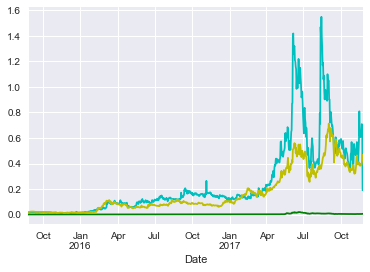

In [13]:
len(SJCX['Close']),len(SC['Close']),len(MAID['Close'])
sj=SJCX['Close'][1191-821:1191]
sc=SC['Close'][0:821]
ma=MAID['Close'][1306-821:1306]

%matplotlib inline
sj.plot(color='c');
sc.plot(color='g');
ma.plot(color='y');

In [14]:
print(sj.tail())
print(sc.tail())
print(ma.tail())

Date
2017-11-19    0.620113
2017-11-20    0.655733
2017-11-21    0.708990
2017-11-22    0.693028
2017-11-23    0.190225
Name: Close, dtype: float64
Date
2017-11-20    0.004286
2017-11-21    0.004412
2017-11-22    0.005391
2017-11-23    0.005275
2017-11-24    0.005052
Name: Close, dtype: float64
Date
2017-11-19    0.396127
2017-11-20    0.388147
2017-11-21    0.409268
2017-11-22    0.424966
2017-11-23    0.467958
Name: Close, dtype: float64


In [15]:
len(SJCX['Close']),len(SC['Close']),len(MAID['Close']), len(sj),len(sc),len(ma)

(1192, 821, 1307, 821, 821, 821)

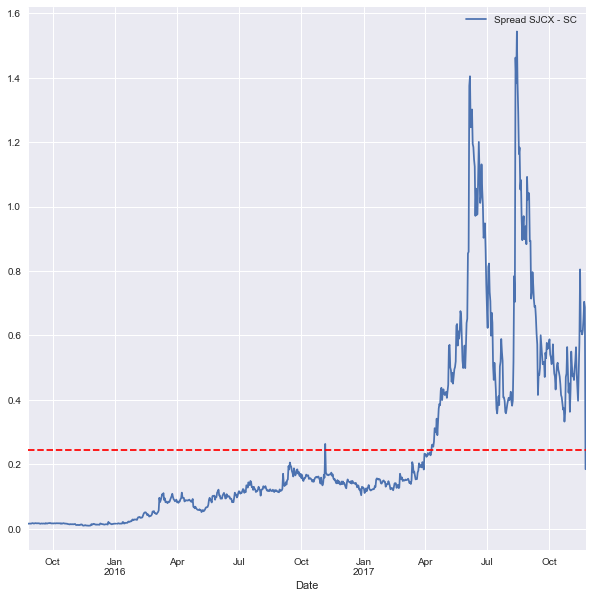

In [16]:
plt.figure(figsize=(10,10))
(sj-sc).plot(label='Spread SJCX - SC');
plt.axhline((sj-sc).mean(), color='red', linestyle='--');
plt.legend();

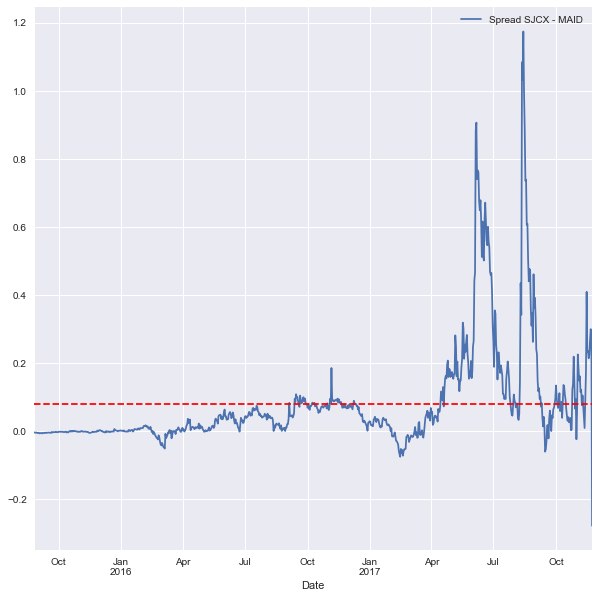

In [17]:
plt.figure(figsize=(10,10))
(sj-ma).plot(label='Spread SJCX - MAID');
plt.axhline((sj-ma).mean(), color='red', linestyle='--');
plt.legend();

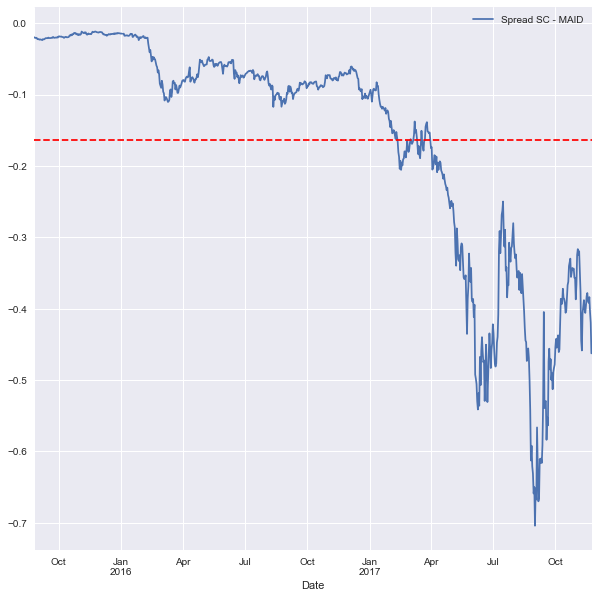

In [18]:
plt.figure(figsize=(10,10))
(sc-ma).plot(label='Spread SC - MAID');
plt.axhline((sc-ma).mean(), color='red', linestyle='--');
plt.legend();

Augmented Engle-Granger test for no-cointegration of a univariate equation

In [19]:
from statsmodels.tsa.stattools import coint
score, pvalue, _ = coint(sj,sc,trend='c')
print(pvalue)

0.00357892889122


In [20]:
score, pvalue, _ = coint(sj,ma,trend='c')
print(pvalue)

0.00164289379741


In [21]:
score, pvalue, _ = coint(sc,ma,trend='c')
print(pvalue)

0.00725360738037


**We strongly reject the null of no cointegration**. It looks like good news now, and we may be able to do trade the pairs.

## Section 2. Improving results

The previous section generated useful insights, but to some extent they were done naively in the sense that we simply subtracted one closing price series from another hoping for their difference to be stationary. We were lucky here, but in general this should not always work. In practice a common way to do this for pairs of time series is to use linear regression to estimate $\beta$ in the following model.

$X2=\alpha+\beta X1+\varepsilon$
 
The idea is that if the two are cointegrated we can remove  X2's depedency on  X1, leaving behind stationary noise. The combination  $X2−\beta X1=\alpha+\varepsilon$ should be stationary.

To solve this we need to make an OLS regression and then take this difference.

In [22]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

sj=pd.DataFrame(sj)
sc=pd.DataFrame(sc)
ma=pd.DataFrame(ma)
#print(sj.tail(),sc.tail(),len(sj),len(sc))
sjsc=[sj,sc]
sjma=[sj,ma]
scma=[sc,ma]
dfsjsc=pd.concat(sjsc,axis=1, join_axes=[sj.index])
dfsjma=pd.concat(sjma,axis=1, join_axes=[sj.index])
dfscma=pd.concat(scma,axis=1, join_axes=[sc.index])
dfsjsc.columns.values[0] = 'SJCl'
dfsjsc.columns.values[1] = 'SCCl' 
dfsjma.columns.values[0] = 'SJCl'
dfsjma.columns.values[1] = 'MACl'
dfscma.columns.values[0] = 'SCCl' 
dfscma.columns.values[1] = 'MACl' 
print(dfsjsc.head())
print(dfsjma.head())
print(dfscma.head())

                SJCl      SCCl
Date                          
2015-08-26  0.015919  0.000041
2015-08-27  0.016157  0.000043
2015-08-28  0.016216  0.000039
2015-08-29  0.016372  0.000034
2015-08-30  0.015846  0.000032
                SJCl      MACl
Date                          
2015-08-26  0.015919  0.019707
2015-08-27  0.016157  0.020216
2015-08-28  0.016216  0.020753
2015-08-29  0.016372  0.020369
2015-08-30  0.015846  0.020846
                SCCl      MACl
Date                          
2015-08-26  0.000041  0.019707
2015-08-27  0.000043  0.020216
2015-08-28  0.000039  0.020753
2015-08-29  0.000034  0.020369
2015-08-30  0.000032  0.020846


In [23]:
modelsjsc=smf.ols('SJCl ~ SCCl',data=dfsjsc).fit()
print(modelsjsc.summary())

                            OLS Regression Results                            
Dep. Variable:                   SJCl   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     2808.
Date:                Wed, 20 Dec 2017   Prob (F-statistic):          1.07e-266
Time:                        11:46:03   Log-Likelihood:                 466.29
No. Observations:                 820   AIC:                            -928.6
Df Residuals:                     818   BIC:                            -919.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1048      0.005     19.123      0.0

In [24]:
modelsjma=smf.ols('SJCl ~ MACl',data=dfsjma).fit()
print(modelsjma.summary())

                            OLS Regression Results                            
Dep. Variable:                   SJCl   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     3707.
Date:                Wed, 20 Dec 2017   Prob (F-statistic):          2.84e-306
Time:                        11:46:03   Log-Likelihood:                 557.62
No. Observations:                 821   AIC:                            -1111.
Df Residuals:                     819   BIC:                            -1102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0161      0.006     -2.652      0.0

In [25]:
modelscma=smf.ols('SCCl ~ MACl',data=dfscma).fit()
print(modelscma.summary())

                            OLS Regression Results                            
Dep. Variable:                   SCCl   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     1703.
Date:                Wed, 20 Dec 2017   Prob (F-statistic):          3.75e-202
Time:                        11:46:03   Log-Likelihood:                 3871.1
No. Observations:                 820   AIC:                            -7738.
Df Residuals:                     818   BIC:                            -7729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0010      0.000     -9.543      0.0

We obtain that the obtained cointegrating vectors for each pair are:

1. **SJ-SC**: (0.1048, 67.0835)
2. **SJ-MA**: (-0.0161,1.5762)
3. **SC-MA**: (-0.0010,0.0188)

Thus, if we plot the new spreads we have the following graphs:

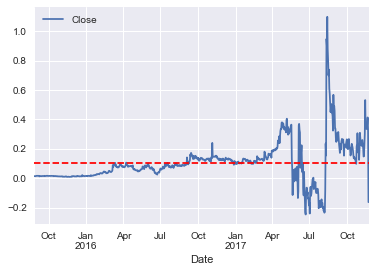

In [26]:
plt.figure(figsize=(10,10))
(sj-67.0835*sc).plot(label='Spread SJ - SC');
plt.axhline(0.1048, color='red', linestyle='--');
plt.legend();

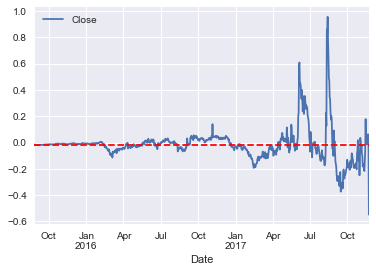

In [27]:
plt.figure(figsize=(10,10))
(sj-1.5762*ma).plot(label='Spread SJ - MA');
plt.axhline(-0.0161, color='red', linestyle='--');
plt.legend();

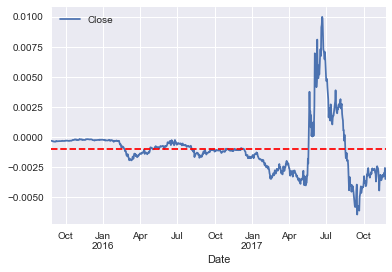

In [28]:
plt.figure(figsize=(10,10))
(sc-0.0188*ma).plot(label='Spread SC - MA');
plt.axhline(-0.0010, color='red', linestyle='--');
plt.legend();

The spreads look a lot better than when we tried estimating them naively. Still, we can do better by appying a rolling beta estimate of the spread. This will be the subject of the next section.

## Section 3. Rolling spreads

In [29]:
def rolling_ols(data1, data2, window =30): #function to finds rolling ols. Window of 30 ad-hoc, ask.

    a = np.array([np.nan] * len(data1)) #empty vector of length len(data1)

    b = [np.nan] * len(data1)  # again, empy vector of length len(data1). If betas required.

    y_ = data2.values #vector consisting of values of data2 (independent variable)

    x_ = sm.add_constant(data1) #vector of regressors consisting of values of data1 including a constant

    for n in range(window, len(data1)): #defining range for the loop n=30,...,len(data1)

        y = y_[(n - window):n] #y is new dependent variable matrix with first (vector) element 
                               #with elements data2.values[30-30:30], second (vector) element with elements
                               #data2.values[31-30:31] and so on until we get to last vector element with elements
                               #data2.values[len(data1)-30:len(data1)]

        X = x_[(n - window):n] #this is independent variable matrix with first element vector of ones, second (vector)
                               #element with elements data1[30-30:30],...,last (vector) element with elements data1[len(data1)-30:len(data1)]
        
        # betas = Inverse(X'.X).X'.y

        betas = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) #rolling betas (how many betas? len(data1)-30)

        b[n] = betas[1].tolist()  # Arrange betas in a list, where b was defined in line 31. If betas required. 

    return b

def find_spread_rolling(data, name1, name2): #function to find rolling spread

    

    S1 = data[name1] #series 1 corresponds to column name of data = name1

    S2 = data[name2] #series 2 corresponds to column name of data = name2

    

    b=rolling_ols(S1, S2, window =60) #find_spread_rolling makes use of the previously defined function rolling_ols
                                      #where the arguments are S1, S2 (name of currencies closing prices), but now we use
                                      #a window of 60, instead of 30. Again, ad-hoc. Ask why?

    spread = S2 - b * S1 #define the spread a the "stationary" component. This relies on S2 and S1 to be integrated processes of order >0, 
                         #and having rejected the null of no cointegration between the series.

    spread.name = 'spread'



    # Get the 1 day moving average of the price spread

    spread_mavg1 = spread.rolling(window=1).mean()

    spread_mavg1.name = 'spread 1d mavg'



    # Get the 30 day moving average

    spread_mavg30 = spread.rolling(window=60).mean() #its actually a 60 day mavg

    spread_mavg30.name = 'spread 30d mavg'

    

    

    # Take a rolling 30 day standard deviation

    std_30 = spread.rolling(window=60).std() #its actually a rolling 60 day std

    std_30.name = 'std 30d'



    # Compute the z score for each day

    zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30

    zscore_30_1.name = 'z-score'

    

    #plotting

    plt.figure()

    plt.plot(spread_mavg1.index, spread_mavg1.values)

    plt.plot(spread_mavg30.index, spread_mavg30.values)

    plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

    plt.title(name1+" "+name2)

    plt.ylabel('Spread');

    

    

    plt.figure()

    zscore_30_1.plot()

    plt.title(name1+" "+name2)

    plt.axhline(0, color='black')

    plt.axhline(1.0, color='red', linestyle='--');

    plt.axhline(-1.0, color='green', linestyle='--');

    

    plt.figure()

    plt.plot(zscore_30_1,b,'k.')

    plt.title(name1+" "+name2+"scatter Zscore/beta")

    plt.ylabel('beta');

    plt.xlabel('Zscore');

We need to join the closing prices into one dataframe

In [37]:
sj.columns.values[0]='sj'
sc.columns.values[0]='sc'
ma.columns.values[0]='ma'
print(sj.head())
print(sc.head())
print(ma.head())
print(len(sj),len(sc),len(ma))

                  sj
Date                
2015-08-26  0.015919
2015-08-27  0.016157
2015-08-28  0.016216
2015-08-29  0.016372
2015-08-30  0.015846
                  sc
Date                
2015-08-26  0.000041
2015-08-27  0.000043
2015-08-28  0.000039
2015-08-29  0.000034
2015-08-30  0.000032
                  ma
Date                
2015-08-26  0.019707
2015-08-27  0.020216
2015-08-28  0.020753
2015-08-29  0.020369
2015-08-30  0.020846
821 821 821


In [38]:
currencies=pd.concat([sj,sc,ma],axis=1)
currencies = currencies.dropna(axis = 0)
print(currencies.head())

                  sj        sc        ma
Date                                    
2015-08-26  0.015919  0.000041  0.019707
2015-08-27  0.016157  0.000043  0.020216
2015-08-28  0.016216  0.000039  0.020753
2015-08-29  0.016372  0.000034  0.020369
2015-08-30  0.015846  0.000032  0.020846


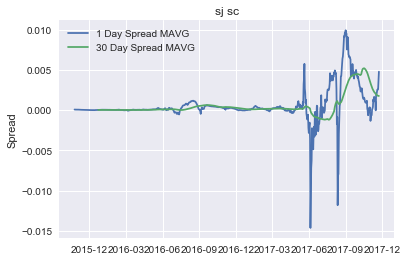

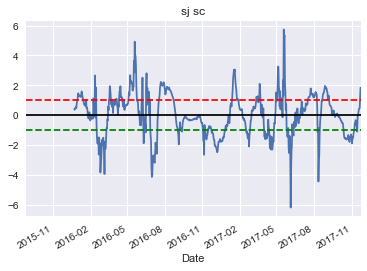

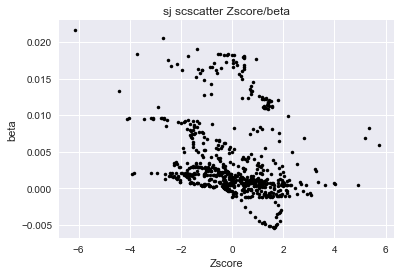

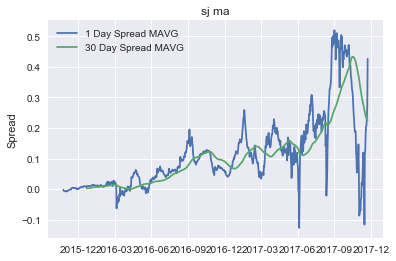

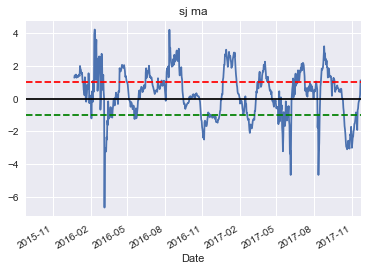

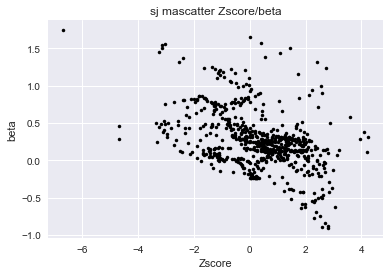

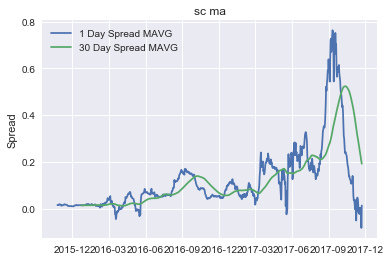

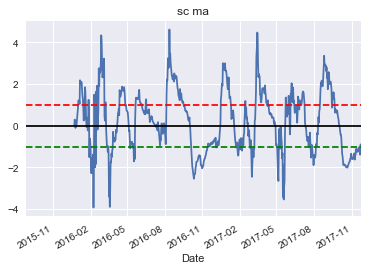

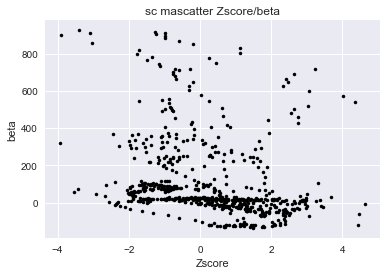

In [47]:
column_names = currencies.keys()
for ii in range(0,len(column_names)):
        for jj in range(ii+1,len(column_names)):
            # get the spread of two columns
            spread = find_spread_rolling(currencies, column_names[ii],column_names[jj]) #key pice of code that computes the spreads
#actually we need to test for cointegration before we even set out to calculate the spreads!
plt.show()

## Section 4. Fundamental analysis

Now that we have some spreads, we should try justify them with some fundamental analysis for the cryptocurrencies. This is no easy task. For starters its not like these cryptocurrencies are companies with financial statements we can look at. Some have only been around very recently and market expectations are only beginning to form around them. We can compare the cryptos around their (1) supplies, (2) blockchain algo/proof type, (3) volume (liquidity concerns), (4) their influence on social media. 


| Currency  | Supply            | Algo/proof type| Average volume     |
|-----------|-------------------|----------------|--------------------|
|   SC      | 31,396,146,174.0  |       POW      | 3,112,297.333739342|
|
|  MAID     |452,552,412.0      |?               |   624123.2104055088|
|
|  STORJ    |424,999,998.0      |?               |   113,768.625      |
||


For influence on social media (based on Cryptocompare: https://www.cryptocompare.com)

![title](Influence/SC.png "ShowMyImage")
![title](Influence/MAID.png "ShowMyImage")
![title](Influence/STORJ.png "ShowMyImage")





In [49]:
avgvol_sj=SJCX['Volume'].mean()
print('Vol_SJ=',avgvol_sj)
avgvol_sc=SC['Volume'].mean()
print('Vol_SC=',avgvol_sc)
avgvol_ma=MAID['Volume'].mean()
print('Vol_MAID=',avgvol_ma)

Vol_SJ= 113768.625
Vol_SC= 3112297.333739342
Vol_MAID= 624123.2104055088
